# Imports

In [11]:
import numpy as np

import lightkurve as lk
from seismolab.OC import OCFitter

import astropy.units as u
from astropy.table import Table, vstack, Column
from astropy.time import Time
from astropy.timeseries import TimeSeries
from astropy.coordinates import SkyCoord, EarthLocation

import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")

CLEAN_ITURBIDE_PATH = "/home/ramon/uanl/thesis/Backup Data/Iturbide/cleaned-iturbide.ecsv"
CLEAN_ZTF_PATH = "/home/ramon/uanl/thesis/Backup Data/IRSA/cleaned-ztf-flux.ecsv"

ZTF_G_DATA_PATH = "/home/ramon/uanl/thesis/Backup Data/IRSA/rel-zg-flux.ecsv"
ZTF_R_DATA_PATH = "/home/ramon/uanl/thesis/Backup Data/IRSA/rel-zr-flux.ecsv"

ORBITAL_PERIOD = 0.3335614 *u.day # from periodogram notebook

ITURBIDE_LOCATION = EarthLocation(lon=-99.895328*u.deg, lat=24.75521 * u.deg, height=2400*u.m)
ATO_NAME = "ATO J339.9469+45.1464"
ATO_COORD = SkyCoord.from_name(ATO_NAME)

# Search TESS in lightkurve

In [31]:
pxFileResults = lk.search_targetpixelfile(target=ATO_NAME)
pxFileResults

No data found for target "ATO J339.9469+45.1464".


SearchResult containing 0 data products.

In [32]:
lcSearchResults = lk.search_lightcurve(target=ATO_NAME)
lcSearchResults

No data found for target "ATO J339.9469+45.1464".


SearchResult containing 0 data products.

# Load Iturbide and ZTF data

In [11]:
iturbideData = Table.read(CLEAN_ITURBIDE_PATH)
iturbideData.remove_column('time')
iturbideData.rename_column('hjd', 'time')
iturbideData

time,mag,err,filter,obsv_date,norm_flux,norm_ferr
,mag,mag,,,,mag
Time,float64,float64,str18,str10,float64,float64
2459924.53372411,1.2622999999999998,0.027856776554368235,Iturbide:Luminance,2022-12-11,1.1607000415833948,0.029780126667358835
2459880.83828183,1.2027999999999999,0.0206155281280883,Iturbide:Luminance,2022-10-28,1.2260833646033908,0.023280384295551036
2459880.83898447,1.2391000000000005,0.0206155281280883,Iturbide:Luminance,2022-10-28,1.1857687481671586,0.02251490635949991
2459880.8396834,1.2197999999999993,0.0206155281280883,Iturbide:Luminance,2022-10-28,1.2070353797212003,0.02291870871873846
2459880.84038222,1.251100000000001,0.022472205054244233,Iturbide:Luminance,2022-10-28,1.1727353057793763,0.02427288336737085
2459922.53610982,1.3013000000000012,0.03956008088970497,Iturbide:Luminance,2022-12-09,1.1197472383220946,0.04079931306510494
2459880.84108104,1.1916999999999973,0.0206155281280883,Iturbide:Luminance,2022-10-28,1.2386824944024528,0.023519611571590764
2459880.84177986,1.191200000000002,0.0206155281280883,Iturbide:Luminance,2022-10-28,1.2392530601392926,0.02353044524734478


In [2]:
%%script echo "skip; will try using raw ZTF data"
ztfData = Table.read(CLEAN_ZTF_PATH)
ztfData.remove_column('time')
ztfData.rename_column('hjd', 'time')
ztfData

skip; will try using raw ZTF data


In [17]:
indivZtfTables = [Table.read(f) for f in [ZTF_G_DATA_PATH, ZTF_R_DATA_PATH]]
ztfData = vstack(indivZtfTables)
ztfData.add_column(" "*5, name='filter') # strings seem to need a specified length
ztfData['filter'][ztfData['filtercode'] == 'zg'] = 'ZTF:g'
ztfData['filter'][ztfData['filtercode'] == 'zr'] = 'ZTF:r'
ztfData.rename_column('hjd', 'time')
ztfData.rename_column('magerr', 'err')
ztfData

oid,expid,time,mjd,mag,err,catflags,filtercode,ra,dec,chi,sharp,filefracday,field,ccdid,qid,limitmag,magzp,magzprms,clrcoeff,clrcounc,exptime,airmass,programid,flux,fluxerr,filter
,,d,d,mag,mag,,,deg,deg,,,,,,,mag,mag,mag,,,s,,,,,
int64,int64,float64,float64,float64,float64,int64,str2,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,str5
771103200012081,47448814,2458228.984821069,58228.4881481,17.5840454,0.0197342671,0,zg,339.9469627,45.1464159,0.361000001,-0.00300000003,20180420488067,771,3,2,20.3199997,26.1658897,0.0215688683,-0.0297699906,1.12665039e-05,30.0,1.80200005,1,0.8512466974342429,0.015472201830924948,ZTF:g
771103200012081,48044724,2458234.944095733,58234.4472454,17.4334183,0.018555779,0,zg,339.9469408,45.1463974,0.931999981,-0.05999999866,20180426447199,771,3,2,19.5400009,25.6539249,0.0282153077,-0.0344086438,1.91989966e-05,30.0,2.12599993,1,0.9779266466675216,0.016713259311285526,ZTF:g
771103200012081,48050421,2458235.001065248,58234.504213,17.4940319,0.0190106239,0,zg,339.9469111,45.1464201,0.649999976,-0.05999999866,20180426504178,771,3,2,20.0400009,26.1324596,0.0191307608,-0.0412657112,8.85321879e-06,30.0,1.51199996,1,0.9248277233109335,0.016193207837325533,ZTF:g
771103200012081,49846564,2458252.963232793,58252.4656481,17.5891399,0.0197770167,0,zg,339.9469224,45.1464253,1.279999971,0.04199999943,20180514465637,771,3,2,21.1599998,26.2559261,0.0154842595,-0.0813824013,5.97686767e-06,30.0,1.44099998,1,0.8472618271845778,0.015433133050246517,ZTF:g
771103200012081,50142988,2458255.9276150335,58255.4298843,17.3031044,0.0176594257,0,zg,339.9469268,45.1464214,0.59799999,-0.01799999923,20180517429873,771,3,2,21.1000004,26.2028542,0.0149421003,-0.0593302026,5.42393491e-06,30.0,1.64900005,1,1.102635168074796,0.017934286191701274,ZTF:g
771103200012081,50747070,2458261.9687530138,58261.470706,17.5298138,0.0192911923,0,zg,339.946875,45.1464203,1.470000029,0.00400000019,20180523470671,771,3,2,21.2000008,26.2077541,0.0167469457,-0.0233822055,6.80576795e-06,30.0,1.28400004,1,0.8948455443904189,0.01589947668686186,ZTF:g
771103200012081,51547567,2458269.974170587,58269.4756713,17.5743046,0.0196530558,0,zg,339.9469458,45.1464186,1.210000038,-0.06700000167,20180531475637,771,3,2,19.7299995,26.2844353,0.0199463703,-0.0297663994,9.64130231e-06,30.0,1.18499994,1,0.858918110413046,0.015547391233341628,ZTF:g
771103200012081,51842940,2458272.928083962,58272.4294097,17.3208179,0.0177750532,0,zg,339.9469204,45.1464128,0.474999994,0.01300000027,20180603429387,771,3,2,20.6200008,26.2381649,0.015438539,-0.0462764166,5.9277836e-06,30.0,1.33700001,1,1.0847919156995953,0.017759593838713103,ZTF:g


In [29]:
allData = vstack([ztfData, iturbideData])
allData.sort('time')
allData

time,mag,err,filter,norm_flux,norm_ferr,obsv_date
,mag,mag,,,mag,
Time,float64,float64,str18,float64,float64,str10
2458228.984821069,17.5840454,0.0197342671,ZTF:g,1.0282138275083825,0.018688744299987674,--
2458234.944095733,17.4334183,0.018555779,ZTF:g,1.1812294877891425,0.020187807339980303,--
2458235.001065248,17.4940319,0.0190106239,ZTF:g,1.1170917385495702,0.01955964147671939,--
2458252.963232793,17.5891399,0.0197770167,ZTF:g,1.023400535775349,0.01864155344375466,--
2458255.9276150335,17.3031044,0.0176594257,ZTF:g,1.3318638767454534,0.021662675584388245,--
2458255.9645266226,16.9123917,0.0152251096,ZTF:r,1.0318182379573217,0.014469026354038484,--
2458258.9544024398,16.8072433,0.0146829495,ZTF:r,1.136743710573925,0.015372749313925446,--
2458261.9687530138,17.5298138,0.0192911923,ZTF:g,1.0808765132361293,0.019204846055618775,--


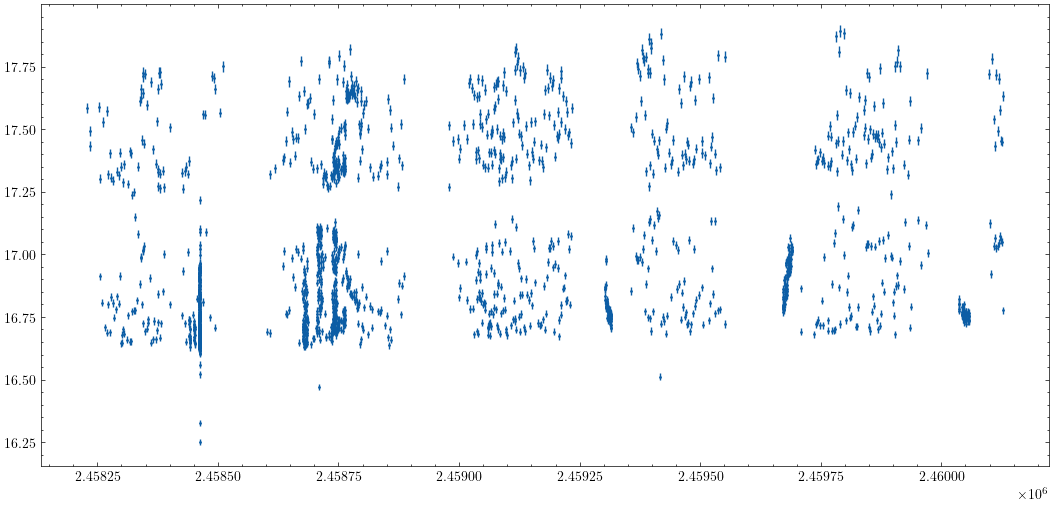

In [19]:
# plt.figure(figsize=(13, 6))
# plt.errorbar(allData['time'].value, allData['norm_flux'], allData['norm_ferr'], marker='.', linestyle='none', markersize=2)

# plt.figure(figsize=(13, 6))
# plt.errorbar(iturbideData['time'].value, iturbideData['norm_flux'], iturbideData['norm_ferr'], marker='.', linestyle='none', markersize=2)

plt.figure(figsize=(13, 6))
plt.errorbar(ztfData['time'].value, ztfData['mag'], ztfData['err'], marker='.', linestyle='none', markersize=2)
plt.show()

# $O - C$ on all data
Using normalized fluxes to determine minima times. Should be compatible since they're all on roughly the same scale, and HJD times should already be calibrated.

In [25]:
# periodChangeData = allData[allData['filter'] == 'ZTF:r']
periodChangeData = ztfData[ztfData['filter'] == 'ZTF:r']

fitter = OCFitter(periodChangeData['time'].value, periodChangeData['mag'].value, periodChangeData['err'].value, ORBITAL_PERIOD.value)
mintimes, mintimes_err = fitter.fit_minima(showfirst=True)
# mintimes, mintimes_err = fitter.fit_minima(showfirst=True, fittype='nonparametric', smoothness=-1)
# mintimes, mintimes_err = fitter.fit_minima(showfirst=True, fittype='poly', order=4)
midtimes, oc, oc_err = fitter.calculate_OC(showplot=True)

Calculating minima times...


LinAlgError: Singular matrix